Cargamos la data historica con sus respectivas variables a revisar y analizar

In [ ]:
#paquetes necesarios para el modelo
install.packages('readxl') # carga del excel
install.packages('dplyr') # manipular datos
install.packages('ggplot2') # graficos
install.packages('caret') # modelos con cv
install.packages('ROCR') # curvas ROC
install.packages('plotROC')
install.packages('rattle')
install.packages('rpart')
library(ROCR)
library(caret)
library(readxl)
library(dplyr)
library(ggplot2)
library(plotROC)
library(rattle)
library(rpart)


In [129]:
install.packages("rpart.plot")
library(rpart.plot)

Installing package into 'C:/Users/MAKEL/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\MAKEL\AppData\Local\Temp\Rtmpysbi4t\downloaded_packages


Warning message:
"package 'rpart.plot' was built under R version 4.3.1"


Revisamos las variables iniciales

In [41]:
data <- read_excel("Modelo.xlsx")
str(data)

tibble [9,170 × 23] (S3: tbl_df/tbl/data.frame)
 $ numero_radicacion        : num [1:9170] 1048 1058 1140 1143 1145 ...
 $ genero                   : chr [1:9170] "M" "M" "F" "M" ...
 $ edad                     : num [1:9170] 51 56 44 53 60 59 49 78 65 48 ...
 $ monto_total_aprobado     : num [1:9170] 2238262 2909931 28438194 16870925 23605567 ...
 $ plazo                    : num [1:9170] 84 36 84 72 96 96 24 60 96 96 ...
 $ puntaje_cifin            : num [1:9170] 520 318 1 219 447 400 734 782 420 289 ...
 $ puntaje_datacredito      : num [1:9170] 520 318 708 1 447 400 734 782 420 289 ...
 $ nueva_pagaduria          : chr [1:9170] "CAJA DE SUELDOS DE RETIRO DE LA POLICIA NACIONAL - CASUR" "CAJA DE SUELDOS DE RETIRO DE LA POLICIA NACIONAL - CASUR" "CAJA DE SUELDOS DE RETIRO DE LA POLICIA NACIONAL - CASUR" "CAJA DE SUELDOS DE RETIRO DE LA POLICIA NACIONAL - CASUR" ...
 $ cuota                    : num [1:9170] 59143 122585 776720 471344 598600 ...
 $ actividad_cliente        : chr [1:91

Comportamientos de variables en mora

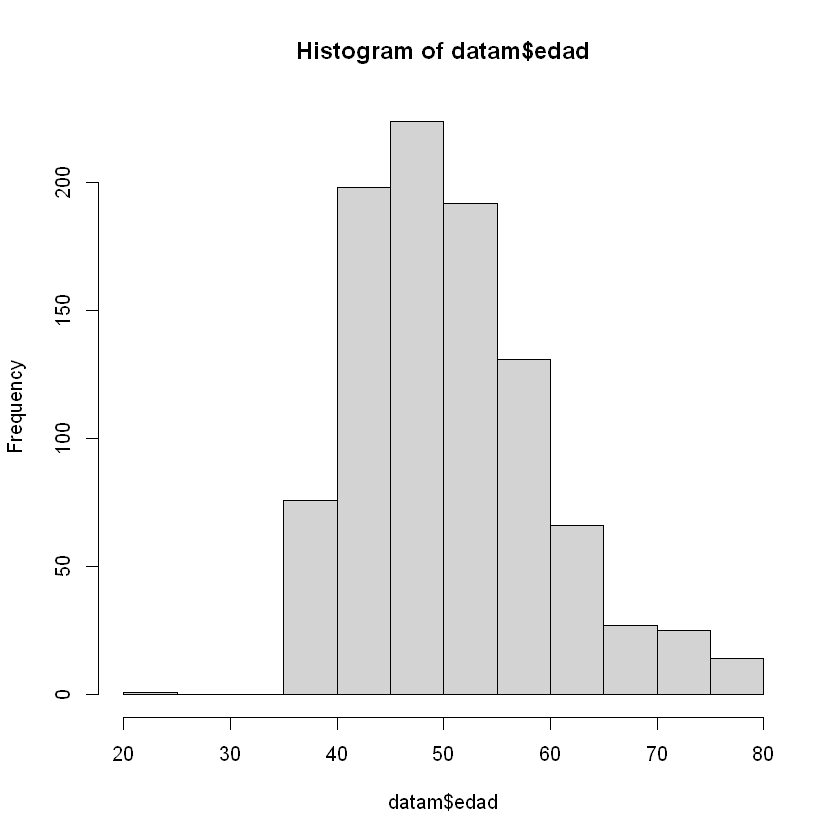

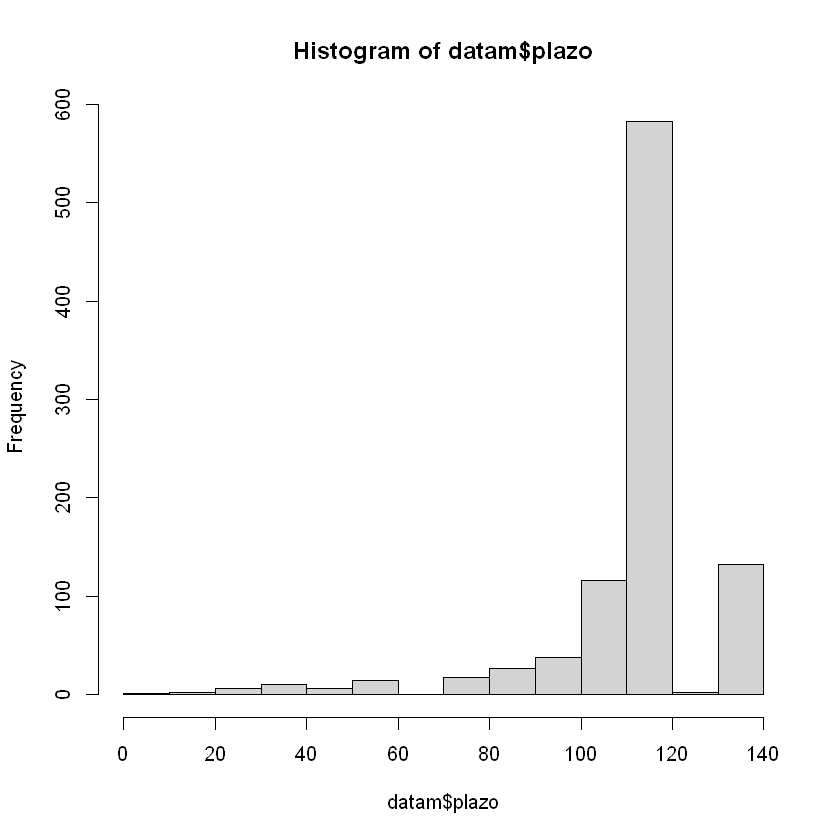

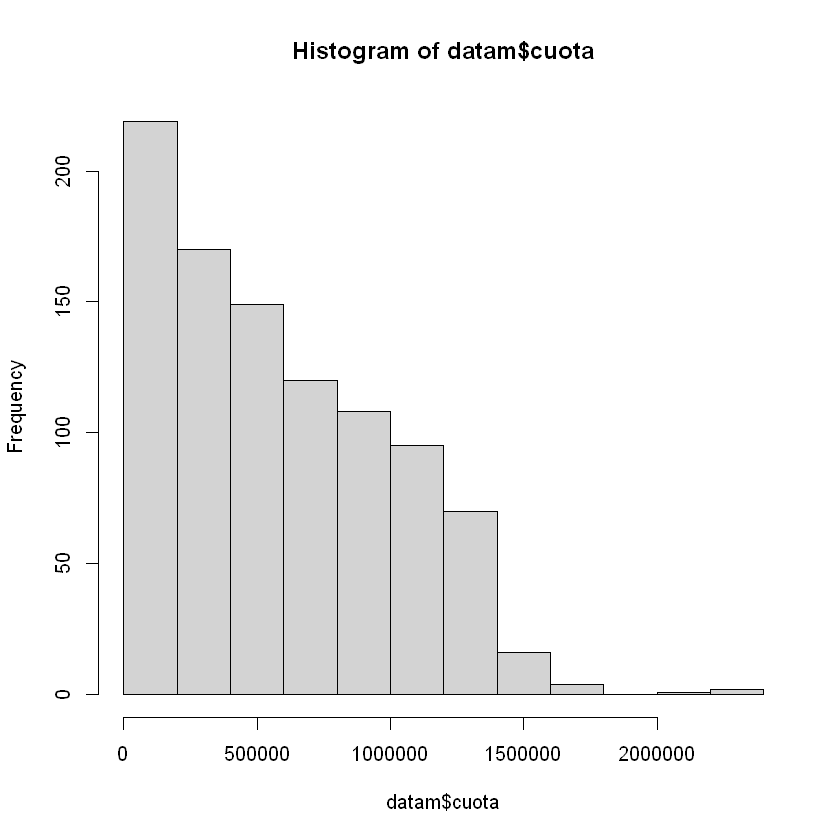

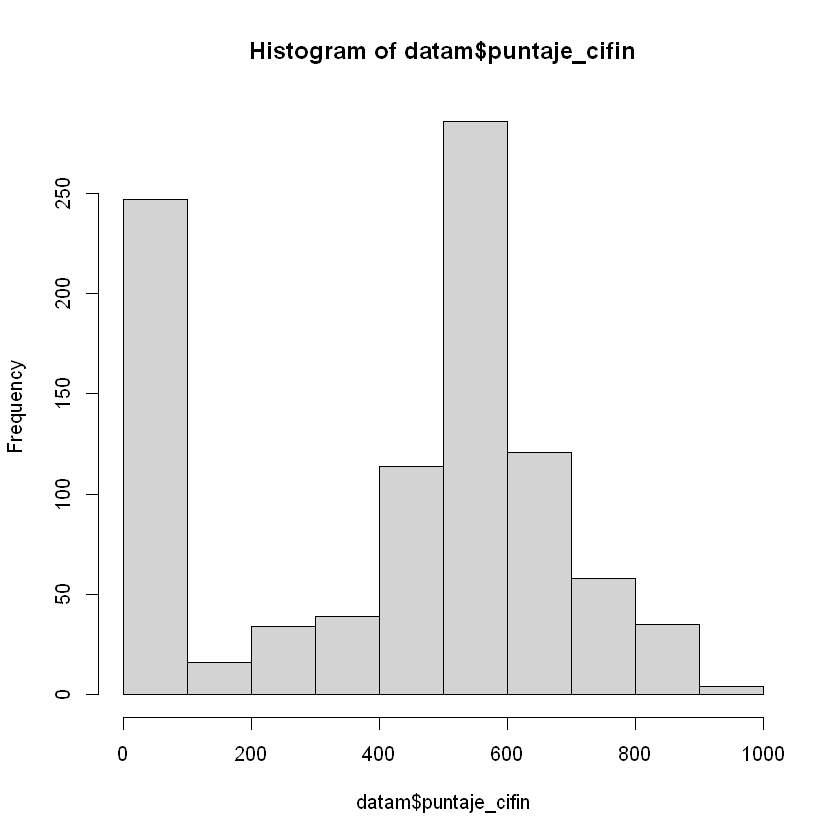

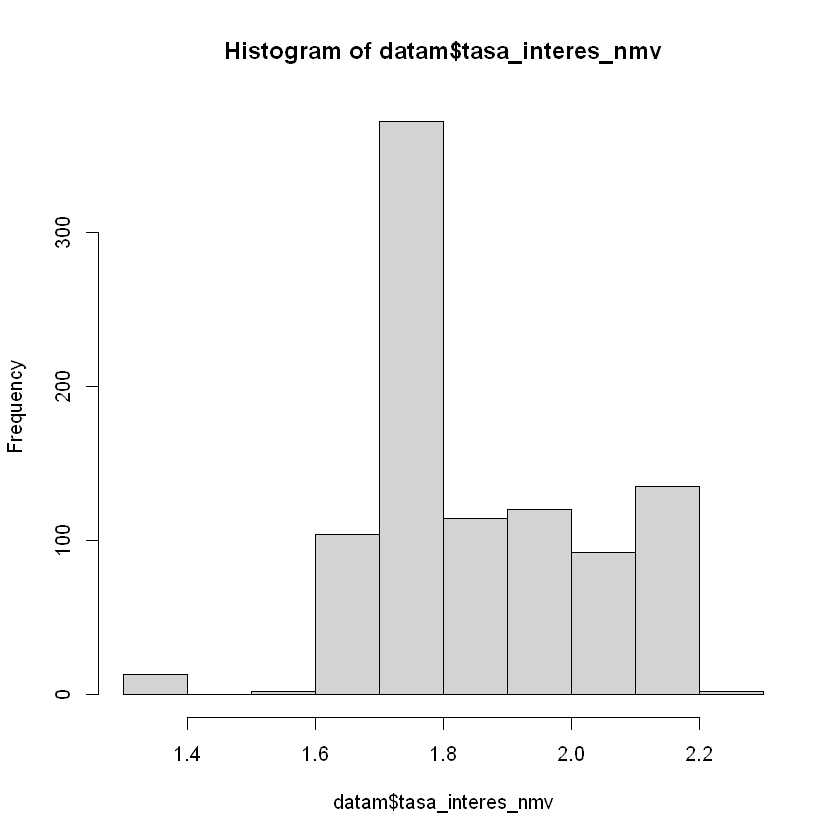

In [44]:
datam <- data %>% filter(comportamiento == 0)
hist(datam$edad)
hist(datam$plazo)
hist(datam$cuota)
hist(datam$puntaje_cifin)
hist(datam$tasa_interes_nmv)

Al tener variables con datos outliers o faltantes como la antiguedad laboral e ingresos , asi como varibales con multimples
categorias estas mismas se excluyen para la primera revision del modelo con las siguientes varibl

In [98]:
mode1 <- read_excel("base_mod.xlsx")
mode1$mora <- as.factor(mode1$mora)
str(mode1)

tibble [9,170 × 14] (S3: tbl_df/tbl/data.frame)
 $ genero              : chr [1:9170] "M" "M" "F" "M" ...
 $ edad                : num [1:9170] 51 56 44 53 60 59 49 78 65 48 ...
 $ monto_total_aprobado: num [1:9170] 2238262 2909931 28438194 16870925 23605567 ...
 $ plazo               : num [1:9170] 84 36 84 72 96 96 24 60 96 96 ...
 $ puntaje_cifin       : num [1:9170] 520 318 1 219 447 400 734 782 420 289 ...
 $ cuota               : num [1:9170] 59143 122585 776720 471344 598600 ...
 $ tasa_interes_nmv    : num [1:9170] 2.09 2.09 2.09 2.04 1.99 ...
 $ estrato             : chr [1:9170] "TRES" "DOS" "DOS" "TRES" ...
 $ estado_civil        : chr [1:9170] "DIVORCIADO" "SOLTERO" "SOLTERO" "CASADO" ...
 $ tipo_vivienda       : chr [1:9170] "FAMILIAR" "FAMILIAR" "FAMILIAR" "FAMILIAR" ...
 $ regional            : chr [1:9170] "Centro" "Centro" "Centro Sur" "Centro Sur" ...
 $ departamento_cliente: chr [1:9170] "Huila" "Bogota D.C" "Bogota D.C" "Bogota D.C" ...
 $ linea_credito       : chr 

Revisamos las proporciones de los creditos en mora y al dia historicos , y realizamos un cross validation para el modelo
al dia = 0 / mora = 1

In [99]:
prop.table(table(mode1$mora)) *100 # al dia = 1 / mora = 0
set.seed(1234)
control <- trainControl(method = "cv", number = 5, classProbs = TRUE, 
summaryFunction = twoClassSummary )


       0        1 
10.40349 89.59651 

Vemos que solo un 10% de la mora del total de la cartera ha entrado en mora

In [101]:
#recodificamos la variable dependiente en factor de dos niveles con etiquetas
#para el sub-muistreo
#mode1.train$mora <- recode(mode1.train$mora, "1=1 ;0=0")
table(mode1$mora) # al dia = 1 / mora = 0
mode1$mora <- as.factor(mode1$mora) # convertimos como factor
mode1$mora = factor(mode1$mora, 
                          levels = levels(mode1$mora),
                          labels = c("0","1"),
                          ordered = F) # agregamos etiquetas
str(mode1$mora) # revisamos los cambios factos dos niveles con labels


   0    1 
 954 8216 

 Factor w/ 2 levels "0","1": 2 2 1 1 2 2 2 2 2 2 ...


Ejecutamos el modelo inicialmente con todas las variables

In [111]:
fit <- train(mora ~ . , data = mode1 , method = "glm", family = binomial(),
 metric = "ROC" , trControl = control  )
 fit
summary(fit)

ERROR: Error: At least one of the class levels is not a valid R variable name; This will cause errors when class probabilities are generated because the variables names will be converted to  X0, X1 . Please use factor levels that can be used as valid R variable names  (see ?make.names for help).


Inicialmente vemos que las varibales mas signifiativas con todos los datos son:

In [80]:
sig.var<- summary(fit)$coeff[-1,4] <0.05
names(sig.var)[sig.var == TRUE]

[1] "generoM"                                   
[2] "edad"                                      
[3] "monto_total_aprobado"                      
[4] "puntaje_cifin"                             
[5] "cuota"                                     
[6] "`linea_creditoRetanqueo Compra de Cartera`"

In [103]:
modex <- glm(mora ~ . , family = 'binomial' , data = mode1)
summary(modex)


Call:
glm(formula = mora ~ ., family = "binomial", data = mode1)

Coefficients:
                                                                               Estimate
(Intercept)                                                                   5.811e-01
generoM                                                                      -3.235e-01
edad                                                                          2.627e-02
monto_total_aprobado                                                         -3.466e-08
plazo                                                                         5.879e-04
puntaje_cifin                                                                 6.857e-04
cuota                                                                         1.222e-06
tasa_interes_nmv                                                             -8.880e-02
estratoCUATRO                                                                 5.746e-01
estratoDOS                             

In [104]:
sig.var<- summary(modex)$coeff[-1,4] <0.05
names(sig.var)[sig.var == TRUE]

[1] "generoM"                                 
[2] "edad"                                    
[3] "monto_total_aprobado"                    
[4] "puntaje_cifin"                           
[5] "cuota"                                   
[6] "linea_creditoRetanqueo Compra de Cartera"

Relaizamos la prediccion del modelo con revision del ajuste, vemos que se ajusta teniendo poca dispersion viendo graficamente

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2378  0.8657  0.9050  0.8960  0.9369  1.0000 

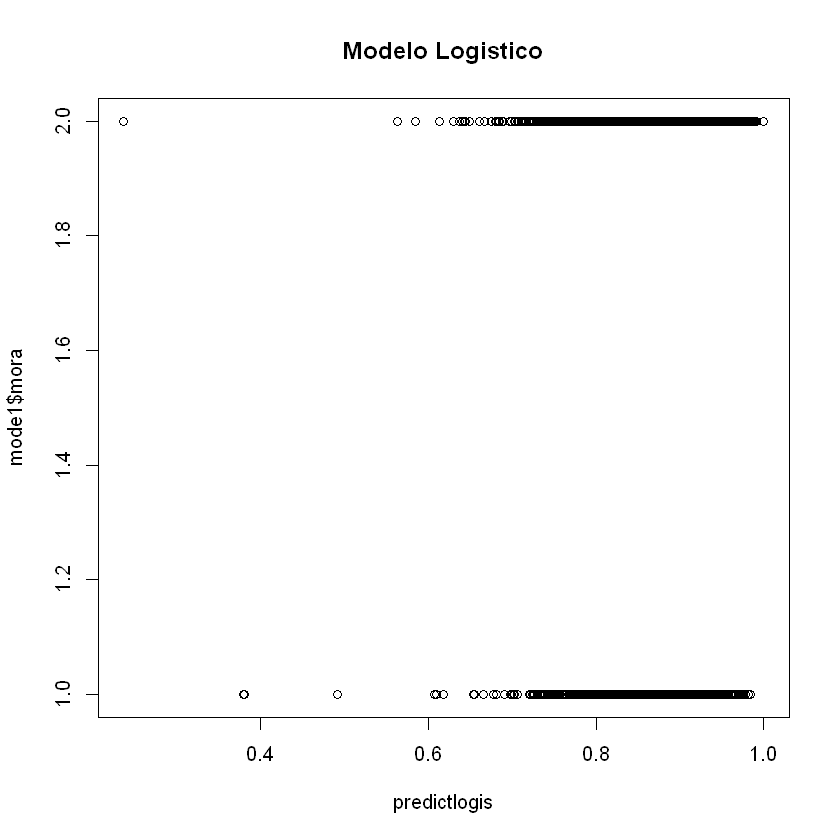

In [105]:
predictlogis <- predict(modex,newdata=mode1, type = 'response')
summary(predictlogis)
plot(predictlogis,mode1$mora, main = "Modelo Logistico")

Aplicamos evaluaciones del modelo

   
       0    1
  0    3  951
  1    1 8215

[1] 0.1038168

AUC 0.6650545 n

NULL

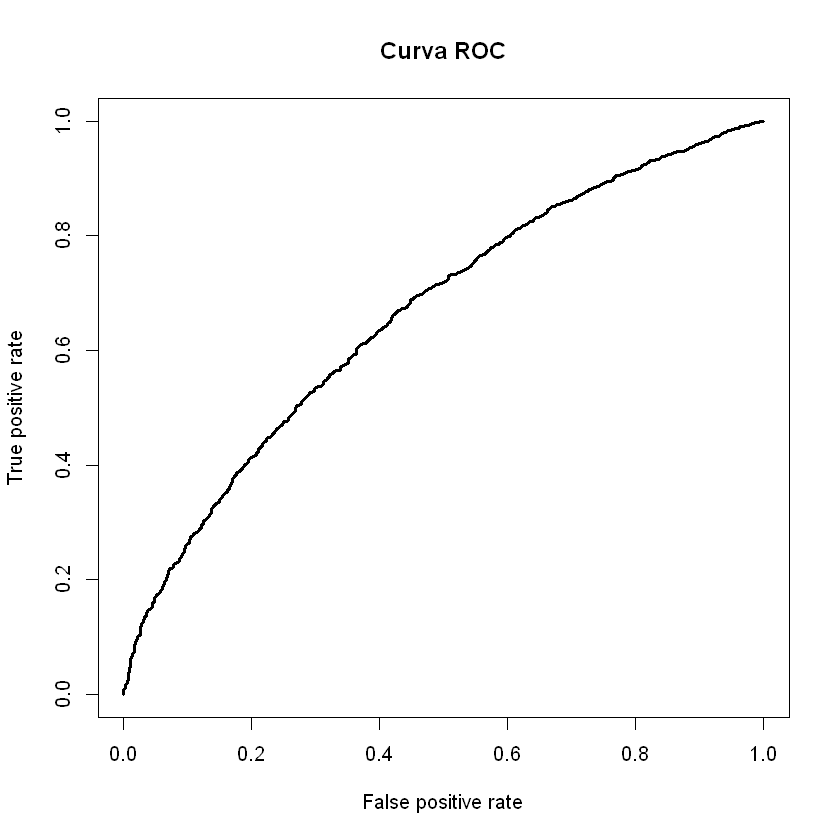

In [118]:
result1 <- table(mode1$mora, floor(predictlogis+0.5)); result1

error1 <- sum(result1[1,2], result1[2,1]) / sum(result1) ; error1

pred <- ROCR::prediction(predictlogis,mode1$mora)
perf <- performance(pred, "tpr", "fpr")
plot(perf, main = 'Curva ROC', lwd = 3)

AUClog1 <- performance(pred, measure = "auc",)@y.values[[1]] 
area1 <- cat("AUC", AUClog1,"n");area1
